In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
os.chdir('/Users/awxlong/Desktop/my-studies/hpc_exps/')

In [3]:
from HistoMIL.DATA.Slide.concepts.feature import Features
from HistoMIL.EXP.paras.env import EnvParas


/Users/awxlong/anaconda3/envs/biomedai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
preprocess_env = EnvParas()

machine_cohort_loc = "/Users/awxlong/Desktop/my-studies/hpc_exps/User/CRC_machine_config.pkl"
with open(machine_cohort_loc, "rb") as f:   # Unpickling
    [data_locs,exp_locs,machine,user] = pickle.load(f)
preprocess_env.data_locs = data_locs
preprocess_env.exp_locs = exp_locs

In [5]:
preprocess_env.collector_para.feature

FeatureParas(model_name='resnet18', device='mps', trans=<function only_naive_transforms at 0x3682a2700>, batch_size=32, cluster_nb=200, with_semantic_shifts=False)

In [6]:
clinical_root = "/Users/awxlong/Desktop/my-studies/temp_data/COAD/Feature/clinical/"


In [7]:
feature_importances = []
cv_scores_f1 = []
cv_scores_auc = []
exclude_columns = ['g0_arrest', 'PatientID']
ensemble_test_preds = []
for fold in os.listdir(clinical_root):

    if fold.startswith('cv'):
        rf_model = RandomForestClassifier(random_state=42)
        train_df = pd.read_csv(os.path.join(clinical_root, fold, 'train.csv'))
        train_df.drop(columns=['Unnamed: 0'], inplace=True)
        train_df.drop_duplicates(inplace=True)
        X_train, y_train = train_df.loc[:, ~train_df.columns.isin(exclude_columns)].values, train_df.loc[:, 'g0_arrest'].values
        rf_model.fit(X_train, y_train)
        # Get feature importances
        importances = rf_model.feature_importances_
        
        val_df = pd.read_csv(os.path.join(clinical_root, fold, 'validation.csv'))
        val_df.drop(columns=['Unnamed: 0'], inplace=True)
        val_df.drop_duplicates(inplace=True)
        X_val, y_val = val_df.loc[:, ~val_df.columns.isin(exclude_columns)].values, val_df.loc[:, 'g0_arrest'].values
        y_pred_val = rf_model.predict_proba(X_val)[:, 1]
        y_pred_val_binarized = (y_pred_val > 0.5).astype(int)
        feature_importances.append(importances)
        cv_scores_f1.append(f1_score(y_val, y_pred_val_binarized))
        cv_scores_auc.append(roc_auc_score(y_val, y_pred_val))

    # if fold.startswith('test'):
        test_df = pd.read_csv(os.path.join(clinical_root, 'test', 'test.csv'))
        test_df.drop(columns=['Unnamed: 0'], inplace=True)
        test_df.drop_duplicates(inplace=True)
        X_test, y_test = test_df.loc[:, ~test_df.columns.isin(exclude_columns)].values, test_df.loc[:, 'g0_arrest'].values
        y_pred_test = rf_model.predict_proba(X_test)[:, 1]
        ensemble_test_preds.append(y_pred_test)

In [8]:
test_df = pd.read_csv(os.path.join(clinical_root, 'test', 'test.csv'))
# test_df.to_csv('test_set.csv')

In [9]:
# Stack the arrays into a 2D array
stacked_preds = np.stack(ensemble_test_preds)

# Calculate the mean across the first axis (axis=0)
mean_test_preds = np.mean(stacked_preds, axis=0)

binarized_test_preds = (mean_test_preds > 0.5).astype(int)

# cluster

In [10]:
testauroc = roc_auc_score(y_test, mean_test_preds)
testf1 = f1_score(y_test, binarized_test_preds)
testauroc, testf1

(0.6022592152199763, 0.5283018867924528)

# local

In [11]:
testauroc = roc_auc_score(y_test, mean_test_preds)
testf1 = f1_score(y_test, binarized_test_preds)
testauroc, testf1

(0.6022592152199763, 0.5283018867924528)

In [12]:
stacked_importances = np.stack(feature_importances)
# Calculate the mean across the first axis (axis=0)
mean_feature_importances = np.mean(stacked_importances, axis=0)


In [13]:
col_names = train_df.loc[:, ~train_df.columns.isin(exclude_columns)].columns
col_names

Index(['Age At Initial Pathologic Diagnosis', 'Lymph Node Examined Count',
       'Preoperative Pretreatment Cea Level', 'Gender_MALE', 'Race_WHITE',
       'Other Dx_Yes', 'Pathologic Stage_Stage II',
       'Pathologic Stage_Stage IIA', 'Pathologic Stage_Stage IIB',
       'Pathologic Stage_Stage III', 'Pathologic Stage_Stage IIIB',
       'Pathologic Stage_Stage IIIC', 'Pathologic Stage_Stage IV',
       'Pathologic Stage_Stage IVA', 'Icd O 3 Histology_Other',
       'Icd O 3 Site_Cecum',
       'Icd O 3 Site_Colon, NOS (Not Otherwise Specified)',
       'Icd O 3 Site_Other', 'Icd O 3 Site_Rectosigmoid junction',
       'Icd O 3 Site_Rectum, NOS', 'Icd O 3 Site_Sigmoid colon',
       'Person Neoplasm Cancer Status_WITH TUMOR', 'Venous Invasion_YES',
       'Lymphatic Invasion_YES', 'History Of Colon Polyps_YES',
       'Residual Tumor_R0',
       'Loss Expression Of Mismatch Repair Proteins By Ihc_YES'],
      dtype='object')

In [23]:
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Clinical Features': col_names,
    'Feature Importance': mean_feature_importances
}).sort_values(by='Feature Importance', ascending=True)

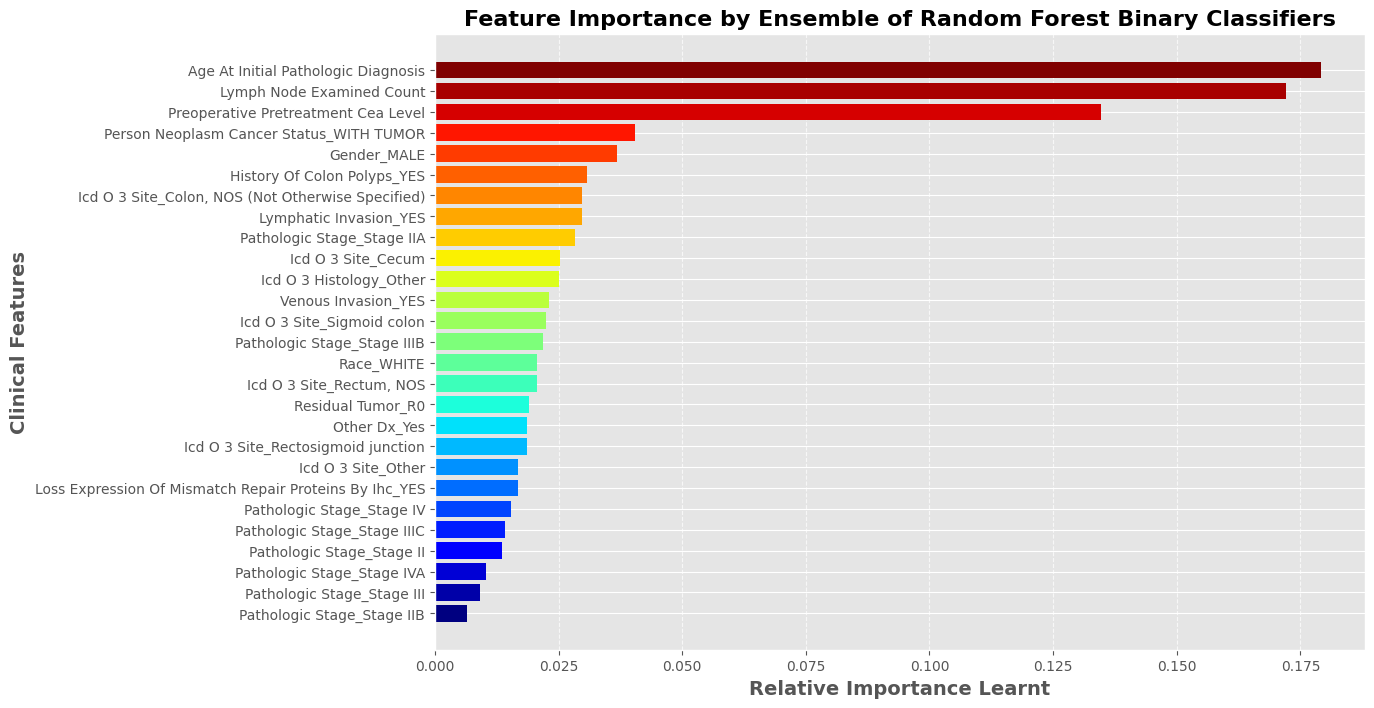

In [28]:
# Assuming feature_importance_df is already defined and contains the necessary data

# Set the figure size and style
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')  # Use a built-in Matplotlib style
# You can use a colormap from Matplotlib or define your own list of colors
num_features = len(feature_importance_df)
colors = plt.cm.jet(np.linspace(0, 1, num_features))  # Using the 'viridis' colormap
# Create a horizontal bar plot
plt.barh(feature_importance_df['Clinical Features'], feature_importance_df['Feature Importance'], color=colors)

# Add labels and title
plt.xlabel('Relative Importance Learnt', fontsize=14, fontweight='bold')
plt.ylabel('Clinical Features', fontsize=14, fontweight='bold')
plt.title('Feature Importance by Ensemble of Random Forest Binary Classifiers', fontsize=16, fontweight='bold')

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Save the figure with high resolution
plt.savefig('feature_importance_plot.png', dpi=224, bbox_inches='tight')  # Save as PNG with high DPI

# Show the plot
plt.show()

In [17]:
# # Assuming feature_importance_df is already defined and contains the necessary data

# # Set the figure size and style
# plt.figure(figsize=(12, 8))
# plt.style.use('ggplot')  # Use a built-in Matplotlib style
# # You can use a colormap from Matplotlib or define your own list of colors
# num_features = len(feature_importance_df)
# colors = plt.cm.jet(np.linspace(1, 0, num_features))  # Using the 'viridis' colormap
# # Create a horizontal bar plot
# plt.barh(feature_importance_df['Clinical Features'], feature_importance_df['Feature Importance'], color=colors)

# # Add labels and title
# plt.xlabel('Relative Importance', fontsize=14)
# plt.ylabel('Clinical Features', fontsize=14)
# plt.title('Feature Importance by Ensemble of Random Forest Binary Classifiers', fontsize=16)

# # Add grid lines for better readability
# plt.grid(axis='x', linestyle='--', alpha=0.7)

# # Save the figure with high resolution
# plt.savefig('feature_importance_plot_local.png', dpi=300, bbox_inches='tight')  # Save as PNG with high DPI

# # Show the plot
# plt.show()

In [20]:
stacked_importances.shape

(5, 27)

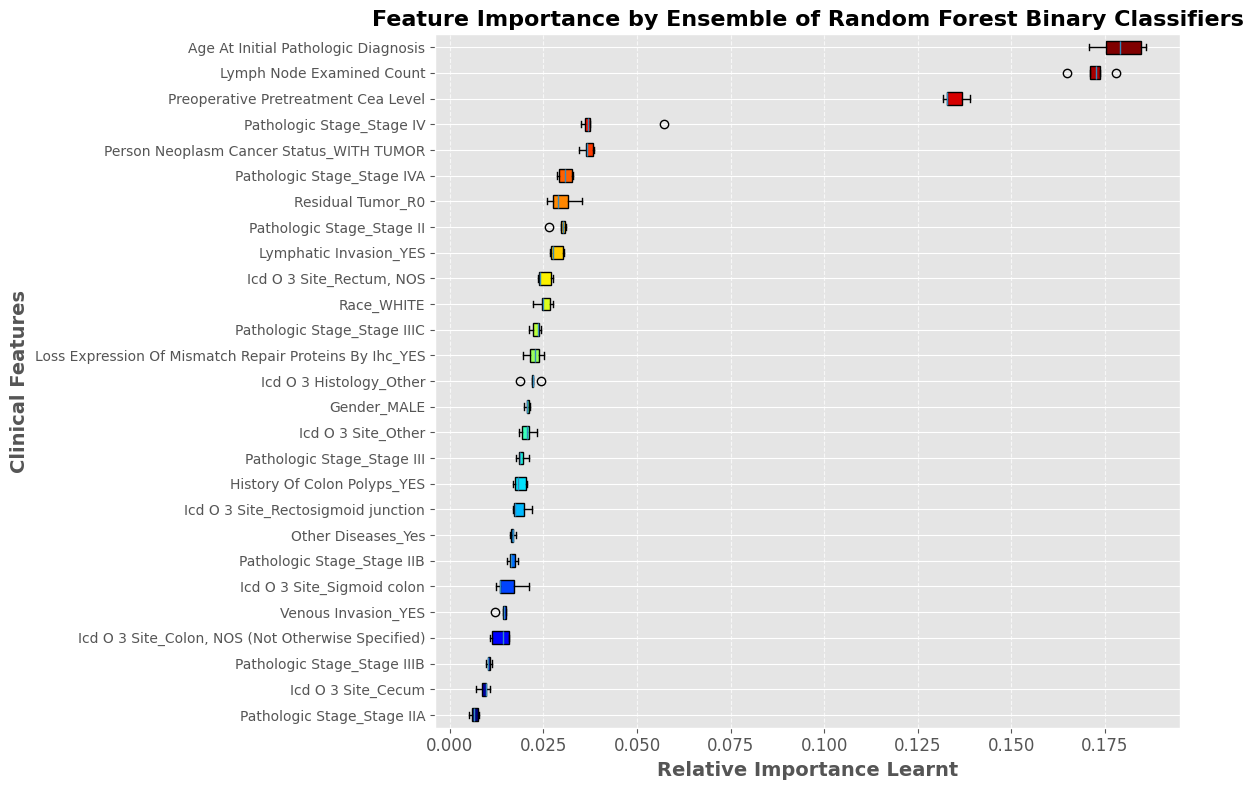

In [22]:
# Get feature names from the DataFrame
feature_names = feature_importance_df['Clinical Features']
feature_names = np.where(feature_names == 'Other Dx_Yes', 'Other Diseases_Yes', feature_names)

# Calculate means for each feature
means = np.mean(stacked_importances, axis=0)

# Sort features by means
sorted_indices = np.argsort(means)
sorted_gradients = stacked_importances[:, sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Generate colors based on the sorted order using the jet colormap
num_features = len(sorted_feature_names)
colors = plt.cm.jet(np.linspace(0, 1, num_features))

# Create horizontal box plots for each feature
plt.figure(figsize=(12, 8))

# Create a horizontal box plot for each of the sorted features
box = plt.boxplot(sorted_gradients, vert=False, labels=sorted_feature_names, patch_artist=True)

# Color the boxes
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add titles and labels with increased font sizes
plt.title('Feature Importance by Ensemble of Random Forest Binary Classifiers', fontsize=16, fontweight='bold' )
plt.xlabel('Relative Importance Learnt', fontsize=14, fontweight='bold')
plt.ylabel('Clinical Features', fontsize=14, fontweight='bold')

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure as a high-resolution image suitable for publication
plt.savefig('feature_importance_plot_ensemble_rf_classifier.png', dpi=224, bbox_inches='tight')

# Show the plot
plt.show()